# Esercitazione 8 - Variational Monte Carlo

## 1 Obiettivo

L'obiettivo di questa esercitazione è la determinazione della funzione d'onda del ground state di una particella nel potenziale 1D
$$
V(x) = x^4 - \frac{5}{2}x^2
$$
Per raggiungere questo obiettivo viene implementato il metodo Variational Monte Carlo.

## 2 Cenni teorici e metodi utilizzati

Il metodo Variational Monte Carlo applica un approcio variazionale per la determinazione dello stato fondamentale di un sistema quantistico. Esso si fonda sul seguente risultato: data l'hamiltoniana $H$ sia $\Psi_0$ la funzione d'onda relativa allo stato fondamentale e $\Psi$ una generica funzione d'onda, allora vale

$$
\langle {\hat H} \rangle = \frac{\langle \Psi| {\hat H} | \Psi \rangle}
{\langle \Psi | \Psi \rangle} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}
$$

L'approcio variazionale consiste quindi nell'eseguire un ansatz sulla funzione d'onda restringendo la ricerca ai parametri che caratterizzano una determinata classe di funzioni, si eseguono quindi misure di $\langle {\hat H} \rangle $ (che chiamerò energia) variando i parametri e si ricerca il minimo. I parametri corrispondenti all'energia minima forniranno la migliore approssimazione dello stato fondamentale.

In questo esercizio si assume che la funzione d'onda dello stato fondamentale del sistema sia la sovrapposizione di due gaussiane disposte simmetricamente rispetto all'asse y

$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

a meno di una costante di normalizzazione che non è necessario conoscere per l'applicazione dell'algoritmo di Metropolis. I parametri liberi sono $\mu$ e $\sigma$. Questo ansatz può essere giustificato osservando la curva del potenziale che suggerisce una funzione d'onda simmetrica rispetto all'asse y e localizzata nelle regioni prossime ai due minimi.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

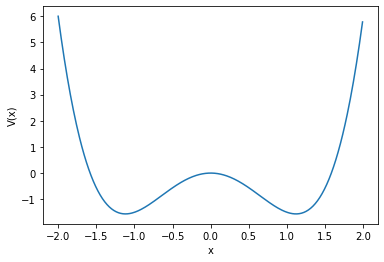

In [2]:
def Vpot(x):
    return (x**2 - 2.5)*x**2

x = np.arange(-2,2,0.01)
plt.plot(x, Vpot(x))
plt.xlabel('x')
plt.ylabel('V(x)')
plt.show()

La parte Monte Carlo di questo metodo risiede nella misura di $\langle {\hat H} \rangle $ che viene fatta campionando il modulo quadro della funzione d'onda con l'algoritmo di Metropolis.

Lo stesso problema può essere risolto anche mediante discretizzazione della funzione d'onda e dell'hamiltoniana. In questo modo è possibile ottenere un'approssimazione della funzione d'onda da soli calcoli matriciali. Il risultato che si ottiene è implementato nella seguente funzione e verrà utilizzato per valutare l'accuratezza dei risultati ottenuti dalla simulazione. Il risultato ottenuto con questo metodo non è legato a nessuna ipotesi sulla forma funzionale di $\Psi_0$.

In [3]:
def psi0():
    hbar = 1
    m = 1
    a = 10
    N = 1000 # number of iterations

    # Step sizes
    x = np.linspace(-a/2, a/2, N)
    dx = x[1] - x[0] # the step size
    V = Vpot(x)

    # The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

    CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
    # np.diag(np.array,k) construct a "diagonal" matrix using the np.array
    # The default is k=0. Use k>0 for diagonals above the main diagonal, 
    # and k<0 for diagonals below the main diagonal

    # Hamiltonian matrix
    H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

    # Compute eigenvectors and their eigenvalues
    E,psi = np.linalg.eigh(H)

    # Take the transpose & normalize
    psi = np.transpose(psi)
    psi = psi/np.sqrt(dx)

    return (x, psi[0])

## 3 Implementazione

Lo scheletro del codice utilizzato è quello realizzato in occasione dell'esercitazione 5. Le classi astratte `TransitionProbability` e `WaveFunction` rappresentano rispettivamente la funzione di transizione con cui vengono proposti i movimenti e la funzione d'onda del sistema quantistico che si vuole simulare. Queste classi forniscono l'interfaccia utilizzata nella funzione principale `main`.

In particolare ho poi utilizzato la specializzazione `UniformTP` della classe `TransitionProbability` che implementa la funzione di trasizione uniforme

$$
T(\vec{x}|\vec{y}) = \cases{1/a^3, \hspace{10pt} |x_1 - y_1| < a/2 \land |x_2 - y_2| < a/2 \land |x_3 - y_3| < a/2 \\
0, \hspace{10pt} \text{otherwise}}
$$

$\vec x$ e $\vec y$ rappresentano due punti successivi del campionamento di Metropolis. Il parametro $a$ è stato regolato in modo tale da ottenere un tasso di accettazione prossimo al 50%.

La classe `WaveFunction` è stata invece specializzata da una classe che implementa la funzione d'onda parametrica 

$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

scelta come ansatz per risolvere l'equazione di Schrödinger con lo specifico potenziale accennato nel primo paragrafo.

Nel `main`, il flusso di istruzioni che è stato implementato è il  seguente:
- vengono letti i parametri di input dal file input.dat
- viene esplorata una griglia di valori di $\mu$ e $\sigma$. Gli estremi e la spaziatura di questa griglia sono forniti come parametri di input.
    Per ogni coppia di parametri ($\mu$, $\sigma$) vengono quindi eseguite le seguenti istruzioni:
    * viene creata una istanza della funzione d'onda $\Psi_T^{\sigma,\mu}(x)$
    * viene stimato il valore dell'energia associata a tale funzione d'onda: viene utilizzato l'algoritmo di Metropolis per campionare punti nello spazio secondo la distribuzione di probabilità data dal modulo quadro della fuzione d'onda. L'energia viene stimata, utilizzando l'algoritmo della media a blocchi, come
    $$\langle {\hat H} \rangle = \frac{\langle \Psi| {\hat H} | \Psi \rangle}
{\langle \Psi | \Psi \rangle}
$$
    * vengono quindi salvati tutti i valori ottenuti su file.

## 4 Utilizzo

Il programma deve essere eseguito senza nessun argomento. Tutti i file di input e output vengono salvati all'interno della cartella `io`.

I parametri della simulazione sono letti dal file `input.dat`, che deve contenere in quest'ordine:
- il numero di blocchi utilizzato nell'algoritmo della media a blocchi in ogni iterazione in cui viene stimata l'energia
- il numero di step totali utilizzati per le stime dell'energia
- il numero di step eseguiti prima di iniziare le misure per portare l'algoritmo di Metropolis alla convergenza asintotica
- l'estremo inferiore dell'intervallo di valori che si vogliono esplorare per $\mu$
- l'estremo superiore dell'intervallo di valori che si vogliono esplorare per $\mu$
- il numero di valori di $\mu$ che si vogliono esplorare tra $\mu_{min}$ e $\mu_{max}$
- l'estremo inferiore dell'intervallo di valori che si vogliono esplorare per $\sigma$
- l'estremo superiore dell'intervallo di valori che si vogliono esplorare per $\sigma$
- il numero di valori di $\sigma$ che si vogliono esplorare tra $\sigma_{min}$ e $\sigma_{max}$
- un valore booleano usato per determinare se salvare tutte le medie di blocco intermedie
- un valore booleano usato per determinare se salvare le coordinate di alcuni punti campionati
- il numero di punti campionati che devono, eventualmente, essere salvati

Il programma può generare i seguenti file di output:
- `blkmeans.output`: contiene i risultati intermedi delle varie iterazioni della media a blocchi. Le colonne contengono, nel seguente ordine:
    * $\mu$ della simulazione a cui appartiene il blocco
    * $\sigma$ della simulazione a cui appartiene il blocco
    * la migliore stima dell'energia all'ultimo blocco simulato
    * la media di blocco del blocco corrispondente alla linea
    * l'incertezza sull'ultima stima
- `final_measures.output`: contiene le stime finali dell'energia con relativa incertezza, ottenuti per ogni coppia di valori ($\mu$, $\sigma$). Le colonne contengono, in quest'ordine: $\mu$, $\sigma$, stima dell'energia, incertezza, tasso di accettazione della simulazione con cui è stata calcolata.
- `points.output`: contiene le coordinate di tutti i punti campionati dei quali è stato richiesto il salvataggio. Le colonne contengono nell'ordine le coordinate x, y e z.

## 5 Problemi riscontrati nell'implementazione

Dopo l'implementazione del codice necessario per la risoluzione del problema in esame, ho notato, durante i primi test, che il campionamento della distribuzione di probabilità con l'algoritmo di Metropolis non funzionava correttamente.

Il grafico seguente mostra un esempio dei risultati ottenuti in questa prima fase

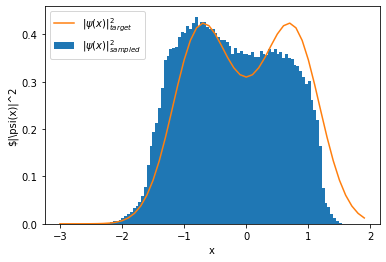

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.integrate as integrate


def double_gauss_unnorm(x, mu, sigma):
    return (np.exp(-0.5*((x-mu)/sigma)**2) + np.exp(-0.5*((x+mu)/sigma)**2))**2

def double_gauss(x, mu, sigma):
    norm_c = integrate.quad(lambda x: double_gauss_unnorm(x, mu, sigma), -100, 100)
    return double_gauss_unnorm(x, mu, sigma)/norm_c[0]

data = np.genfromtxt('../08/VariationalMC/io_old/points.output', usecols=(2), unpack=True)
plt.hist(data, 100, density=True, label='$|\\psi(x)|^2_{sampled}$')
plt.xlabel('x')
plt.ylabel('$|\\psi(x)|^2')
mu = 0.771
sigma = 0.608
x = np.arange(-3,2,0.1)

plt.plot(x, double_gauss(x, mu, sigma), label='$|\\psi(x)|^2_{target}$')
plt.legend(loc='best')
plt.show()

Come si può vedere questa distribuzione presenta un bias verso sinistra che non si risolve variando il numero di punti campionati ($10^6$ in questo grafico).

Dopo diversi controlli ed esperimenti ho osservato che il problema si risolveva con l'aggiunta di una ulteriore chiamata al generatore di numeri casuali prima di ogni estrazione all'interno della funzione di transizione.
Suppongo quindi che questo effetto sia dovuto in qualche modo alla correlazione tra due estrazioni successive di numeri pseudocasuali.

In conclusione ho risolto questo problema implementando, all'interno della classe `UniformTP` utilizzata come funzione di transizione, un algoritmo di rimescolamento dei numeri casuali estratti.
Il funzionamento è il seguente:
- nel costruttore della classe viene riempito con 100 numeri pseudocasuali (estratti uniformemente tra 0 e 1) il vettore `random_numbers` e viene estratto un ulteriore numero salvandolo in `random_index`.
- quando serve estrarre un numero casuale:
    *  si usa `random_numbers[random_index*100]` come nuova estrazione
    * lo stesso numero viene salvato come nuovo `random_index`
    * l'elemento `random_numbers[random_index*100]` viene aggiornato con un nuovo numero casuale
    
Questo rimescolamento permette di evitare le correlazioni. È inoltre una tecnica più efficiente dell'estrazione "a vuoto" di altri numeri. Nel paragrafo successivo si può apprezzare come i risultati ottenuti in questo modo siano notevolmente diversi da quelli del grafico sopra.

## 6 Risultati ottenuti

Ho quindi applicato il codice realizzato alla risoluzione dell'equazione di Schrödinger con il potenziale dato.
Il metodo variazionale che ho utilizzato consiste nella ricerca dei parametri $\mu$ e $\sigma$ che minimizzino la stima dell'energia.

Come già accennato, il programma realizzato è in grado di eseguire una serie di stime dell'energia tramite l'algoritmo di Metropolis variando i parametri della funzione d'onda in una griglia dalle caratteristiche specificate.

Ho risolto l'esercizio in più passaggi:
innanzitutto ho eseguito una simulazione variando i parametri su una ampia griglia. Ho quindi realizzato un grafico del valore di $\langle H \rangle$ ottenuto in modo da restringere la ricerca ad una regione più piccola dello spazio dei parametri. Ho eseguito nuovamente una simulazione esplorando tale regione con una griglia più fitta. Infine ho eseguito una simulazione con i parametri trovati in corrispondenza del minimo salvando anche tutti i risultati intermedi.

### 5.1 Ricerca dei parametri che minimizzano l'energia

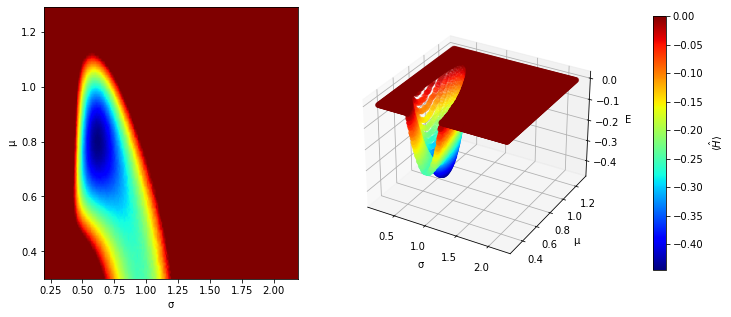

In [14]:
(mu, sigma, energy,err) = np.genfromtxt('../08/VariationalMC/large_grid/final_measures.output', unpack=True, usecols=(0,1,2,3))

z = energy.reshape(100, 200)
z[z>0] = 0
z = np.flip(z,0)

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax1.imshow(z, extent=(np.amin(sigma), np.amax(sigma), np.amin(mu), np.amax(mu)), aspect = 'auto', cmap='jet')
ax1.set(xlabel='σ', ylabel='μ')
ax2.set(xlabel='σ', ylabel='μ', zlabel='E')
jet = ax2.scatter(sigma, mu, energy, cmap='jet', c=energy)

axins = inset_axes(ax2,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.2, 0., 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,
                   )

cbar = plt.colorbar(jet, cax=axins)
cbar.set_label('$\\langle \hat H \\rangle$')
fig.set_size_inches(10, 5)
#plt.tight_layout()
plt.show()

Come si può vedere in questo grafico, il minimo si trova in una regione centrata intorno a $\mu=0.8$ e $\sigma=0.75$. Per poter meglio apprezzare la superficie in corrispondenza del minimo, tutti i valori di energia positivi sono stati posti uguali a 0.

Ho quindi realizzato una simulazione variando i parametri in modo che:
- $\mu \in [0.6, 0.9]$
- $\sigma \in [0.5, 0,8]$

Per ciascuno dei parametri sono stati esplorati 100 valori. In questo modo i valori ottenuti per il punto di minimo saranno noti con una incertezza di 0.003 pari al passo della griglia.

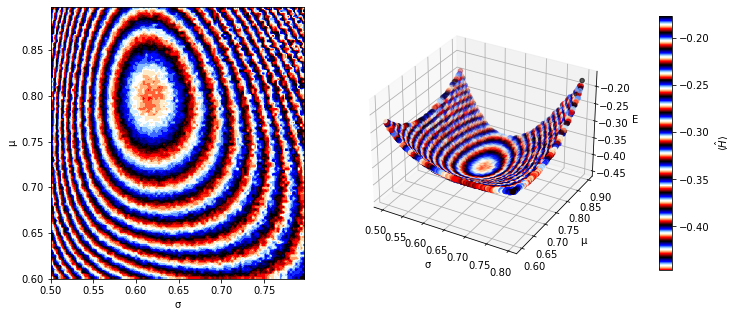

In [15]:
(mu, sigma, energy) = np.genfromtxt('../08/VariationalMC/small_grid/final_measures.output', unpack=True, usecols=(0,1,2))

z = energy.reshape(100, 100)
z[z>0] = 0
z = np.flip(z,0)

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax1.imshow(z, extent=(np.amin(sigma), np.amax(sigma), np.amin(mu), np.amax(mu)), aspect = 'auto', cmap='flag')
ax1.set(xlabel='σ', ylabel='μ')
ax2.set(xlabel='σ', ylabel='μ', zlabel='E')
jet = ax2.scatter(sigma, mu, energy, cmap='flag', c=energy)

axins = inset_axes(ax2,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.2, 0., 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,
                   )

cbar = plt.colorbar(jet, cax=axins)
cbar.set_label('$\\langle \hat H \\rangle$')
fig.set_size_inches(10, 5)
#plt.tight_layout()
plt.show()

Questi grafici mostrano i risultati di quest'ultima esplorazione dello spazio dei parametri. Da questi dati sono stati estratti i valori a cui corrisponde il minimo.

In [18]:
#trovo il minimo
index = np.argmin(energy)
print('Minimo')
print(f"mu:\t\t {mu[index]} ± 0.003")
print(f"sigma:\t\t {sigma[index]} ± 0.003")
print(f"energia:\t {energy[index]:.3} ± {err[index]:.1} ")

Minimo
mu:		 0.798 ± 0.003
sigma:		 0.614 ± 0.003
energia:	 -0.446 ± 0.002 


### 5.2 Simulazione con i parametri selezionati

Con i valori di $\mu$ e $\sigma$ trovati, ho quindi eseguito una ulteriore simulazione salvando l'evoluzione della stima nel corso della media a blocchi e alcuni dei punti campionati.
Ho utilizzato $10^7$ punti divisi in 100 blocchi. Ho inoltre effettuato una fase iniziale di equilibrazione estraendo "a vuoto" 100 punti.

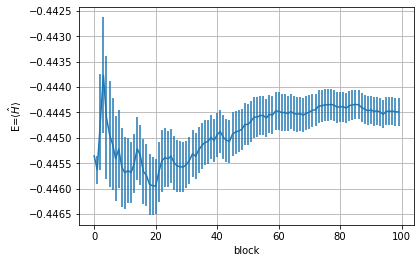

stima finale dell'energia: -0.4445
incertezza: 0.0003


In [19]:
ene, err = np.genfromtxt('../08/VariationalMC/io_min/blkmeans.output', usecols=(3,4), unpack=True)
x = np.arange(0, len(ene))
plt.errorbar(x, ene, err)
plt.xlabel("block")
plt.ylabel('E=$\\langle \\hat H \\rangle$')
plt.grid()
plt.show()

print(f"stima finale dell'energia: {ene[-1]:.4f}")
print(f"incertezza: {err[-1]:.1}")

Il grafico mostra il progressivo miglioramento della stima dell'energia all'aumentare del numero di blocchi considerato. Il risultato finale ottenuto è espresso in unità di codice adimensionali.

Questo risultato può essere confrontato con quello ottenibile mediante discretizzazione della funzione d'onda, pari a 
$$
E_0 = -0.4605
$$

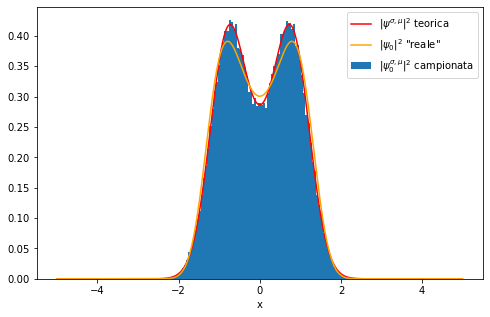

In [20]:
data = np.genfromtxt('../08/VariationalMC/io_min/points.output', usecols=(2), unpack=True)
plt.hist(data, 100, density=True, label='$|\\psi^{\\sigma, \\mu}_0|^2$ campionata')
teo_psi = psi0()
x = np.arange(-5, 5, 0.01)
plt.plot(x, double_gauss(x, 0.798,0.614), color='red', label='$|\\psi^{\\sigma, \\mu}|^2$ teorica')
plt.plot(teo_psi[0], teo_psi[1]**2, color='orange', label='$|\\psi_0|^2$ "reale"')
plt.xlabel('x')
fig = plt.gcf()
fig.set_size_inches(8,5)
plt.legend(loc='best')
plt.show()

In quest'ultimo grafico viene invece rappresentata la distribuzione di probabilità campionata, costruendo un istogramma normalizzato dei diversi punti campionati.

Nello stesso grafico è anche rappresentata la curva teorica della distribuzione di probabilità campionata (in rosso) e la curva del modulo quadro della funzione d'onda del ground state, determinata tramite il metodo della discretizzazione (in arancione). 

Come si può osservare la funzione d'onda viene campionata correttamente. L'ansatz fatto ha permesso di trovare una funzione d'onda che si avvicina molto a quella "reale" determinata con il metodo della discretizzazione. Anche l'energia trovata differisce da quella esatta solo dalla seconda cifra decimale. I due valori non sono comunque compatibili se si considera l'incertezza statistica della misura. Questa discrepanza potrebbe essere spiegata col fatto che i valori dei parametri trovati non siano esattamente quelli del punto di minimo, in questo caso si potrebbe giungere a risultati migliori esplorando lo spazio dei parametri con una griglia più fitta o implementando un qualche algoritmo di ottimizzazione più efficiente.
Come ulteriore ipotesi, l'ansatz fatto per la funzione d'onda potrebbe non essere preciso: la $\psi_0$ potrebbe avere una forma differente dalla forma funzionale ipotizzata. In questo caso il risultato potrebbe essere migliorato soltanto modificando questa ipotesi. Questo metodo ha infatti il limite di dover ipotizzare una specifica forma funzionale (parametrica) per la funzione d'onda. 